In [1]:
# import os
# os.environ["PYTENSOR_FLAGS"] = "cxx="
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import pytensor.tensor as pt

plt.rcParams["figure.figsize"] = (12, 4)
az.rcParams["stats.hdi_prob"] = 0.94
print('done')

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


done


c:\Users\Hp\Desktop\brent-oil-change-point-analysis\.venv\Lib\site-packages\arviz\rcparams.py:345: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


In [2]:
df = pd.read_csv("../data/raw/BrentOilPrices.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df["log_price"] = np.log(df["Price"])
df["log_return"] = df["log_price"].diff()

df = df.dropna(subset=["log_return"]).reset_index(drop=True)
df.head()


C:\Users\Hp\AppData\Local\Temp\ipykernel_4992\1555838161.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


,Date,Price,log_price,log_return
0,1987-05-21,18.45,2.915064,-0.009709
1,1987-05-22,18.55,2.920470,0.005405
2,1987-05-25,18.60,2.923162,0.002692
3,1987-05-26,18.63,2.924773,0.001612
4,1987-05-27,18.60,2.923162,-0.001612


In [3]:
start = pd.Timestamp("2018-01-01")
end = pd.Timestamp("2022-09-30")

df_decade = df[(df["Date"] >= start) & (df["Date"] <= end)].copy().reset_index(drop=True)
r = df_decade["log_return"].values
dates = df_decade["Date"].values

len(r), df_decade["Date"].min(), df_decade["Date"].max()


(1208, Timestamp('2018-01-02 00:00:00'), Timestamp('2022-09-30 00:00:00'))

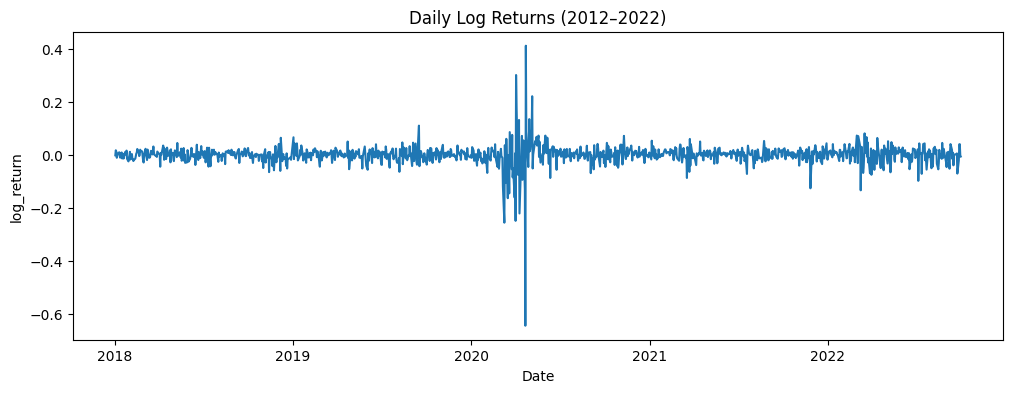

In [4]:
plt.figure()
plt.plot(df_decade["Date"], r)
plt.title("Daily Log Returns (2012–2022)")
plt.xlabel("Date")
plt.ylabel("log_return")
plt.show()


In [5]:
# Standardize returns for better geometry
r_std = (r - r.mean()) / r.std()
T = len(r_std)
t = np.arange(T)

with pm.Model() as soft_cp_fast:
    tau = pm.Uniform("tau", lower=0, upper=T-1)

    mu1 = pm.Normal("mu1", 0.0, 1.0)
    mu2 = pm.Normal("mu2", 0.0, 1.0)
    sigma = pm.HalfNormal("sigma", 1.0)

    k = 0.1  # fixed smoothness (do NOT sample k)
    w = pm.math.sigmoid(k * (t - tau))
    mu_t = (1 - w) * mu1 + w * mu2

    obs = pm.Normal("obs", mu=mu_t, sigma=sigma, observed=r_std)

    idata_soft = pm.sample(
        draws=250,
        tune=250,
        chains=1,
        cores=1,
        target_accept=0.9,
        random_seed=42,
        idata_kwargs={"log_likelihood": True},
    )


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tau, mu1, mu2, sigma]


Output()

c:\Users\Hp\Desktop\brent-oil-change-point-analysis\.venv\Lib\site-packages\pymc\step_methods\hmc\quadpotential.py:
316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)

Sampling 1 chain for 250 tune and 250 draw iterations (250 + 250 draws total) took 9517 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [6]:
az.summary(idata_soft, var_names=["tau", "mu1", "mu2", "sigma"])


arviz - WARNING - Shape validation failed: input_shape: (1, 250), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,718.963,400.219,72.368,1206.101,188.897,16.380,5.0,75.0,NaN
mu1,0.008,0.051,-0.099,0.089,0.007,0.013,62.0,32.0,NaN
mu2,-0.069,0.169,-0.370,0.139,0.035,0.035,42.0,60.0,NaN
sigma,1.003,0.020,0.969,1.040,0.002,0.001,92.0,106.0,NaN


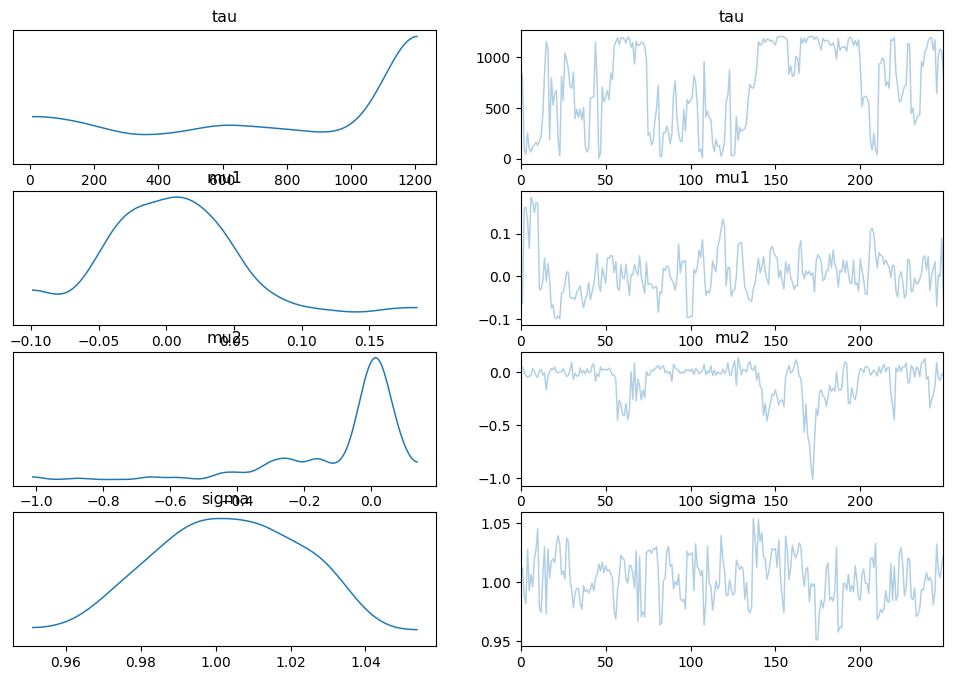

In [7]:
az.plot_trace(idata_soft, var_names=["tau", "mu1", "mu2", "sigma"])
plt.show()


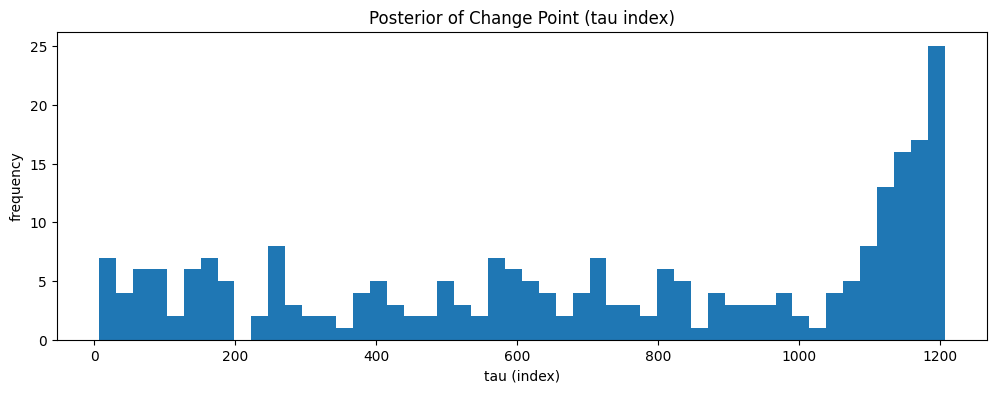

(752,
 Timestamp('2020-12-11 00:00:00'),
 array([  72, 1206]),
 (Timestamp('2018-04-16 00:00:00'), Timestamp('2022-09-29 00:00:00')))

In [8]:
tau_samples = idata_soft.posterior["tau"].values.flatten().astype(int)

plt.figure()
plt.hist(tau_samples, bins=50)
plt.title("Posterior of Change Point (tau index)")
plt.xlabel("tau (index)")
plt.ylabel("frequency")
plt.show()

tau_median = int(np.median(tau_samples))
tau_date = df_decade.loc[tau_median, "Date"]

tau_hdi = az.hdi(tau_samples, hdi_prob=0.94)
tau_hdi_dates = (df_decade.loc[int(tau_hdi[0]), "Date"], df_decade.loc[int(tau_hdi[1]), "Date"])

tau_median, tau_date, tau_hdi, tau_hdi_dates


In [9]:
mu1_s = idata_soft.posterior["mu1"].values.flatten()
mu2_s = idata_soft.posterior["mu2"].values.flatten()
delta = mu2_s - mu1_s

print("P(mu2 > mu1) =", (delta > 0).mean())
print("Delta mean (mu2-mu1):", np.mean(delta))
print("94% HDI delta:", az.hdi(delta, hdi_prob=0.94))


P(mu2 > mu1) = 0.404
Delta mean (mu2-mu1): -0.07687346877486538
94% HDI delta: [-0.38118905  0.16356614]


In [10]:
with pm.Model() as model_t:
    tau = pm.DiscreteUniform("tau", lower=0, upper=T-1)

    mu1 = pm.Normal("mu1", mu=0.0, sigma=0.02)
    mu2 = pm.Normal("mu2", mu=0.0, sigma=0.02)

    sigma = pm.HalfNormal("sigma", sigma=0.05)
    nu = pm.Exponential("nu", lam=1/10) + 2  # df > 2

    mu_t = pm.math.switch(pt.arange(T) < tau, mu1, mu2)

    obs = pm.StudentT("obs", nu=nu, mu=mu_t, sigma=sigma, observed=r)

    idata_t = pm.sample(
        draws=300,
        tune=300,
        chains=1,
        cores=1,                 # IMPORTANT on Windows
        target_accept=0.9,
        random_seed=42,          
        idata_kwargs={"log_likelihood": True},
    )

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma, nu]


Output()

Sampling 1 chain for 300 tune and 300 draw iterations (300 + 300 draws total) took 6537 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [11]:
cmp = az.compare({"Normal": idata_soft, "StudentT": idata_t}, method="BB-pseudo-BMA", ic="waic")
cmp

c:\Users\Hp\Desktop\brent-oil-change-point-analysis\.venv\Lib\site-packages\arviz\stats\stats.py:1652: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
StudentT,0,2710.514679,5.871655,0.000000,1.0,40.856382,0.000000,False,log
Normal,1,-1743.665396,41.667738,4454.180075,0.0,165.933756,161.480316,True,log


In [24]:
# # events = pd.read_csv(
# #     "../data/events/brent_key_events.csv",
# #     skip_blank_lines=True
# # )

# # events["event_date"] = pd.to_datetime(
# #     events["event_date"].astype(str).str.strip(),
# #     format="%Y-%m-%d",
# #     errors="coerce"
# # )

# # events[events["event_date"].isna()]

# events = pd.read_csv(
#     "../data/events/brent_key_events.csv",
#     skip_blank_lines=True,
#     index_col=False
# )

# events["event_date"] = pd.to_datetime(events["event_date"], format="%Y-%m-%d", errors="coerce")
# events.head()

import pandas as pd
import csv

events_clean = pd.DataFrame([
    {
        "event_date": "2014-11-27",
        "event_name": "OPEC maintains production despite oversupply",
        "category": "OPEC Policy",
        "description": "OPEC decided not to cut production, accelerating the 2014–2015 oil price collapse",
        "expected_market_channel": "Oversupply / negative price pressure",
    },
    {
        "event_date": "2015-07-14",
        "event_name": "Iran nuclear deal (JCPOA) signed",
        "category": "Geopolitics/Sanctions",
        "description": "Agreement raised expectations of Iranian oil returning to market",
        "expected_market_channel": "Future supply increase",
    },
    {
        "event_date": "2016-11-30",
        "event_name": "OPEC production cut agreement",
        "category": "OPEC Policy",
        "description": "OPEC agreed to coordinated production cuts after prolonged low prices",
        "expected_market_channel": "Supply restriction / price support",
    },
    {
        "event_date": "2018-05-08",
        "event_name": "US withdrawal from Iran nuclear deal",
        "category": "Geopolitics/Sanctions",
        "description": "US announced exit from JCPOA and future sanctions on Iran",
        "expected_market_channel": "Supply risk / price increase",
    },
    {
        "event_date": "2018-06-22",
        "event_name": "OPEC agrees to increase output",
        "category": "OPEC Policy",
        "description": "OPEC responded to rising prices by increasing production",
        "expected_market_channel": "Supply increase / price moderation",
    },
    {
        "event_date": "2019-09-14",
        "event_name": "Attack on Saudi Aramco facilities",
        "category": "Conflict",
        "description": "Drone attack temporarily disrupted Saudi oil production",
        "expected_market_channel": "Supply disruption / risk premium",
    },
    {
        "event_date": "2020-03-06",
        "event_name": "OPEC+ talks collapse",
        "category": "OPEC+/Geopolitics",
        "description": "Saudi Arabia and Russia failed to agree on cuts",
        "expected_market_channel": "Price war / sharp price decline",
    },
    {
        "event_date": "2020-04-20",
        "event_name": "Oil demand collapse during COVID-19",
        "category": "Economic Shock",
        "description": "Global demand collapsed leading to extreme price dislocations",
        "expected_market_channel": "Demand shock / extreme volatility",
    },
    {
        "event_date": "2021-07-18",
        "event_name": "OPEC+ agreement to increase production",
        "category": "OPEC Policy",
        "description": "OPEC+ agreed to gradually increase output as demand recovered",
        "expected_market_channel": "Supply increase",
    },
    {
        "event_date": "2022-02-24",
        "event_name": "Russia invades Ukraine",
        "category": "Conflict",
        "description": "Invasion triggered sanctions and supply concerns",
        "expected_market_channel": "Supply risk / price surge",
    },
    {
        "event_date": "2022-06-03",
        "event_name": "EU sanctions on Russian oil announced",
        "category": "Sanctions/Policy",
        "description": "EU agreed on phased ban of Russian seaborne oil imports",
        "expected_market_channel": "Medium-term supply constraint",
    },
])

# write a valid CSV with proper quoting
events_clean.to_csv("../data/events/brent_key_events.csv", index=False, quoting=csv.QUOTE_MINIMAL)

# read back and parse dates (with explicit format to remove warning)
events = pd.read_csv("../data/events/brent_key_events.csv")
events["event_date"] = pd.to_datetime(events["event_date"], format="%Y-%m-%d")
events.head()


,event_date,event_name,category,description,expected_market_channel
0,2014-11-27,OPEC maintains production despite oversupply,OPEC Policy,"OPEC decided not to cut production, accelerati...",Oversupply / negative price pressure
1,2015-07-14,Iran nuclear deal (JCPOA) signed,Geopolitics/Sanctions,Agreement raised expectations of Iranian oil r...,Future supply increase
2,2016-11-30,OPEC production cut agreement,OPEC Policy,OPEC agreed to coordinated production cuts aft...,Supply restriction / price support
3,2018-05-08,US withdrawal from Iran nuclear deal,Geopolitics/Sanctions,US announced exit from JCPOA and future sancti...,Supply risk / price increase
4,2018-06-22,OPEC agrees to increase output,OPEC Policy,OPEC responded to rising prices by increasing ...,Supply increase / price moderation


In [25]:
# events = pd.read_csv("../data/events/brent_key_events.csv")
# events["event_date"] = pd.to_datetime(events["event_date"])

tau_date = pd.Timestamp(df_decade.loc[tau_median, "Date"])
events["days_from_tau"] = (events["event_date"] - tau_date).dt.days

events.sort_values("days_from_tau").head(8)[
    ["event_date", "event_name", "category", "days_from_tau", "expected_market_channel"]
]


,event_date,event_name,category,days_from_tau,expected_market_channel
0,2014-11-27,OPEC maintains production despite oversupply,OPEC Policy,-2206,Oversupply / negative price pressure
1,2015-07-14,Iran nuclear deal (JCPOA) signed,Geopolitics/Sanctions,-1977,Future supply increase
2,2016-11-30,OPEC production cut agreement,OPEC Policy,-1472,Supply restriction / price support
3,2018-05-08,US withdrawal from Iran nuclear deal,Geopolitics/Sanctions,-948,Supply risk / price increase
4,2018-06-22,OPEC agrees to increase output,OPEC Policy,-903,Supply increase / price moderation
5,2019-09-14,Attack on Saudi Aramco facilities,Conflict,-454,Supply disruption / risk premium
6,2020-03-06,OPEC+ talks collapse,OPEC+/Geopolitics,-280,Price war / sharp price decline
7,2020-04-20,Oil demand collapse during COVID-19,Economic Shock,-235,Demand shock / extreme volatility


Change Point Interpretation

The Bayesian change point model detects a structural break occurring after April 2020. Although major events such as the COVID-19 demand collapse and OPEC+ price war precede the detected change point, the posterior suggests a regime shift during the post-shock recovery period. This indicates a delayed or cumulative market adjustment rather than an immediate response to a single event. The COVID-19 demand collapse remains the closest major preceding event and provides the most plausible economic context for the observed structural change.